# PhaseNet Example

Applying GaMMA to associate PhaseNet picks

In [1]:
# !pip install git+https://github.com/wayneweiqiang/GaMMA.git

In [2]:
import pandas as pd
from gamma.utils import association, estimate_eps
import numpy as np
import os
from pyproj import Proj


## 1. Download demo data

There are two examples in the demo data: Ridgecrest, CA and Chile.

**Phase Picks**:
- test_data/ridgecrest
    - picks.csv
    - stations.csv
    - standard_catalog.csv
- test_data/chile
    - picks.csv
    - stations.csv
    - iasp91.csv

**Results**:
- test_data/ridgecrest
    - gamma_events.csv
    - gamma_picks.csv
- test_data/chile
    - gamma_events.csv
    - gamma_picks.csv

In [3]:
#region = "ridgecrest"
region = "chile"
data_path = lambda x: os.path.join(f"test_data1/{region}", x)
result_path = f"results/{region}"
if not os.path.exists(result_path):
    os.makedirs(result_path)
result_path = lambda x: os.path.join(f"results/{region}", x)
station_csv = data_path("stations.csv")
picks_csv = data_path("picks.csv")
if not os.path.exists("figures"):
    os.makedirs("figures")
figure_dir = lambda x: os.path.join("figures", x)

In [4]:
## read picks
picks = pd.read_csv(picks_csv, parse_dates=["phase_time"])
picks.rename(columns={"station_id": "id", "phase_time": "timestamp", "phase_type": "type", "phase_score": "prob", "phase_amplitude": "amp"}, inplace=True)
print("Pick format:", picks.iloc[:10])

## read stations
stations = pd.read_csv(station_csv)
stations.rename(columns={"station_id": "id"}, inplace=True)
print("Station format:", stations.iloc[:10])

## Automatic region; you can also specify a region
x0 = stations["longitude"].median()
y0 = stations["latitude"].median()
xmin = stations["longitude"].min()
xmax = stations["longitude"].max()
ymin = stations["latitude"].min()
ymax = stations["latitude"].max()
config = {}
config["center"] = (x0, y0)
config["xlim_degree"] = (2 * xmin - x0, 2 * xmax - x0)
config["ylim_degree"] = (2 * ymin - y0, 2 * ymax - y0)

## projection to km
proj = Proj(f"+proj=sterea +lon_0={config['center'][0]} +lat_0={config['center'][1]} +units=km")
stations[["x(km)", "y(km)"]] = stations.apply(lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1)
stations["z(km)"] = stations["elevation_m"].apply(lambda x: -x/1e3)

### setting GMMA configs
config["use_dbscan"] = True
if region == "chile":
    config["use_amplitude"] = False
else:
    config["use_amplitude"] = True
config["method"] = "BGMM"  
if config["method"] == "BGMM": ## BayesianGaussianMixture
    config["oversample_factor"] = 5
if config["method"] == "GMM": ## GaussianMixture
    config["oversample_factor"] = 1

# earthquake location
config["vel"] = {"p": 6.0, "s": 6.0 / 1.75}
config["dims"] = ['x(km)', 'y(km)', 'z(km)']
config["x(km)"] = proj(longitude=config["xlim_degree"], latitude=[config["center"][1]] * 2)[0]
config["y(km)"] = proj(longitude=[config["center"][0]] * 2, latitude=config["ylim_degree"])[1]
if region == "ridgecrest":
    config["z(km)"] = (0, 20)
elif region == "chile":
    config["z(km)"] = (0, 250)
else:
    print("Please specify z(km) for your region")
    raise NotImplementedError
config["bfgs_bounds"] = (
    (config["x(km)"][0] - 1, config["x(km)"][1] + 1),  # x
    (config["y(km)"][0] - 1, config["y(km)"][1] + 1),  # y
    (0, config["z(km)"][1] + 1),  # z
    (None, None),  # t
)

# DBSCAN
config["dbscan_eps"] = estimate_eps(stations, config["vel"]["p"])
config["dbscan_min_samples"] = 3

# using Eikonal for 1D velocity model
if region == "ridgecrest":
    zz = [0.0, 5.5, 16.0, 32.0]
    vp = [5.5, 5.5,  6.7,  7.8]
    vp_vs_ratio = 1.73
    vs = [v / vp_vs_ratio for v in vp]
    h = 1.0
    vel = {"z": zz, "p": vp, "s": vs}
    config["eikonal"] = {"vel": vel, "h": h, "xlim": config["x(km)"], "ylim": config["y(km)"], "zlim": config["z(km)"]}
elif region == "chile":
    velocity_model = pd.read_csv(data_path("iasp91.csv"), names=["zz", "rho", "vp", "vs"])
    velocity_model = velocity_model[velocity_model["zz"] <= config["z(km)"][1]]
    vel = {"z": velocity_model["zz"].values, "p": velocity_model["vp"].values, "s": velocity_model["vs"].values}
    h = 1.0
    config["eikonal"] = {"vel": vel, "h": h, "xlim": config["x(km)"], "ylim": config["y(km)"], "zlim": config["z(km)"]}
else:
    print("Using uniform velocity model")

if region == "chile":
    config["initial_points"] = [1, 1, 1] # x, y, z

# set number of cpus
config["ncpu"] = 32

# filtering
config["min_picks_per_eq"] = 5
config["min_p_picks_per_eq"] = 0
config["min_s_picks_per_eq"] = 0
config["max_sigma11"] = 3.0 # second
config["max_sigma22"] = 1.0 # log10(m/s)
config["max_sigma12"] = 1.0 # covariance

## filter picks without amplitude measurements
if config["use_amplitude"]:
    picks = picks[picks["amp"] != -1]

for k, v in config.items():
    print(f"{k}: {v}")


Pick format:           id               timestamp      prob type
0   CX.PB01. 2014-03-15 10:22:28.230  0.951574    P
1   CX.PB09. 2014-03-15 10:22:28.710  0.945726    P
2   CX.PB02. 2014-03-15 10:22:32.140  0.775383    P
3   CX.PB07. 2014-03-15 10:22:32.940  0.863010    P
4   CX.PB08. 2014-03-15 10:22:33.080  0.906363    P
5   CX.PB03. 2014-03-15 10:22:33.460  0.944506    P
6  CX.PATCX. 2014-03-15 10:22:35.570  0.905085    P
7   CX.PB06. 2014-03-15 10:22:38.060  0.885528    P
8   CX.PB11. 2014-03-15 10:22:38.660  0.922071    P
9  CX.PSGCX. 2014-03-15 10:22:43.030  0.616448    P
Station format:          id  longitude  latitude  elevation_m
0  CX.PB01.  -69.48740 -21.04323        900.0
1  CX.PB02.  -69.89603 -21.31973       1015.0
2  CX.PB03.  -69.75310 -22.04847       1460.0
3  CX.PB04.  -70.14918 -22.33369       1520.0
4  CX.PB05.  -70.20235 -22.85283       1150.0
5  CX.PB06.  -69.57188 -22.70580       1440.0
6  CX.PB07.  -69.88618 -21.72667       1570.0
7  CX.PB08.  -69.15340 -20.1411

In [5]:
stations

,id,longitude,latitude,elevation_m,x(km),y(km),z(km)
0,CX.PB01.,-69.48740,-21.043230,900.0,34.533280,15.270774,-0.900
1,CX.PB02.,-69.89603,-21.319730,1015.0,-7.925274,-15.309004,-1.015
2,CX.PB03.,-69.75310,-22.048470,1460.0,6.869117,-96.000871,-1.460
3,CX.PB04.,-70.14918,-22.333690,1520.0,-33.952291,-127.621277,-1.520
4,CX.PB05.,-70.20235,-22.852830,1150.0,-39.287201,-185.131767,-1.150
5,CX.PB06.,-69.57188,-22.705800,1440.0,25.460200,-168.817756,-1.440
6,CX.PB07.,-69.88618,-21.726670,1570.0,-6.884308,-60.366980,-1.570
7,CX.PB08.,-69.15340,-20.141120,3060.0,69.663937,115.041269,-3.060
8,CX.PB09.,-69.24192,-21.796380,1530.0,59.743413,-68.194837,-1.530
9,CX.PB10.,-70.55408,-23.513430,250.0,-75.040336,-258.447075,-0.250


## 2. Associaiton with GaMMA

In [6]:
event_idx0 = 0 ## current earthquake index
assignments = []
standard_catalog, assignments = association(picks, stations, config, event_idx0, config["method"])
event_idx0 += len(standard_catalog)

## create catalog
standard_catalog = pd.DataFrame(standard_catalog)
standard_catalog[["longitude","latitude"]] = standard_catalog.apply(lambda x: pd.Series(proj(longitude=x["x(km)"], latitude=x["y(km)"], inverse=True)), axis=1)
standard_catalog["depth_km"] = standard_catalog["z(km)"]
standard_catalog.to_csv(result_path("gamma_events.csv"), index=False, 
                float_format="%.3f",
                date_format='%Y-%m-%dT%H:%M:%S.%f')

## add assignment to picks
assignments = pd.DataFrame(assignments, columns=["pick_index", "event_index", "gamma_score"])
picks = picks.join(assignments.set_index("pick_index")).fillna(-1).astype({'event_index': int})
picks.to_csv(result_path("gamma_picks.csv"), index=False, 
                date_format='%Y-%m-%dT%H:%M:%S.%f')

Loading precomputed timetable...
Associating 11020 clusters with 8 CPUs


## 3. Visualize results

Note that the location and magnitude are estimated during associaiton, which are not expected to have high accuracy. 

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
result_label="GaMMA"
catalog_label="Standard"

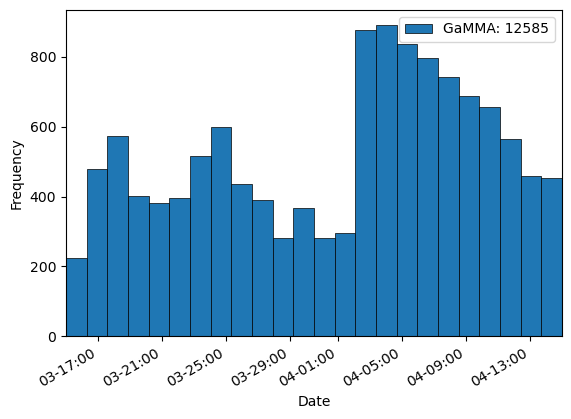

In [8]:
stations = pd.read_csv(data_path("stations.csv"))
gamma_events = pd.read_csv(result_path("gamma_events.csv"), parse_dates=["time"])

if os.path.exists(data_path("standard_catalog.csv")):
    standard_catalog = pd.read_csv(data_path("standard_catalog.csv"), parse_dates=["time"])
    starttime = standard_catalog["time"].min()
    endtime = standard_catalog["time"].max()
else:
    standard_catalog = None
    starttime = gamma_events["time"].min()
    endtime = gamma_events["time"].max()


plt.figure()
plt.hist(gamma_events["time"], range=(starttime, endtime), bins=24, edgecolor="k", alpha=1.0, linewidth=0.5, label=f"{result_label}: {len(gamma_events['time'])}")
if standard_catalog is not None:
    plt.hist(standard_catalog["time"], range=(starttime, endtime), bins=24, edgecolor="k", alpha=0.6, linewidth=0.5, label=f"{catalog_label}: {len(standard_catalog['time'])}")
plt.ylabel("Frequency")
plt.xlabel("Date")
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.savefig(figure_dir("earthquake_number.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("earthquake_number.pdf"), bbox_inches="tight")
plt.show();

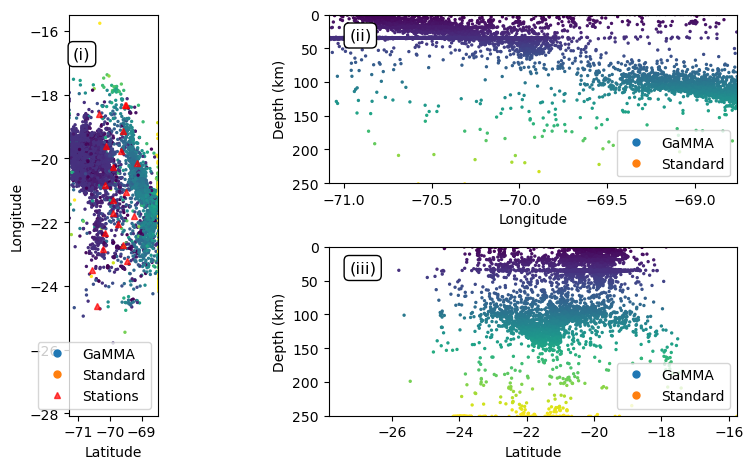

In [13]:
fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([1.5,1]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.92]
grd = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.5, 1], height_ratios=[1,1])
fig.add_subplot(grd[:, 0])
plt.scatter(gamma_events["longitude"], gamma_events["latitude"], s=2, c=gamma_events["z(km)"])
if standard_catalog is not None:
    plt.plot(standard_catalog["longitude"], standard_catalog["latitude"], '.', markersize=5, alpha=0.6)
plt.axis("scaled")
plt.xlim(np.array(config["xlim_degree"]))
plt.ylim(np.array(config["ylim_degree"]))
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.gca().set_prop_cycle(None)
plt.plot([], [], '.', markersize=10, label=f"{result_label}", rasterized=True)
plt.plot([], [], '.', markersize=10, label=f"{catalog_label}", rasterized=True)
plt.plot(stations["longitude"], stations["latitude"], 'r^', markersize=5, alpha=0.7, label="Stations")
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[0, 1])
plt.scatter(gamma_events["longitude"], gamma_events["depth_km"], c=gamma_events["z(km)"], s=2, alpha=1.0, rasterized=True)
if standard_catalog is not None:
    plt.scatter(gamma_events["longitude"], gamma_events["depth_km"], c=gamma_events["z(km)"], s=5, alpha=0.6, rasterized=True)
plt.xlim(np.array(config["xlim_degree"])+np.array([0.2,-0.27]))
plt.ylim(config["z(km)"])
plt.gca().invert_yaxis()
plt.xlabel("Longitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot([], [], '.', markersize=10, label=f"{result_label}")
plt.plot([], [], '.', markersize=10, label=f"{catalog_label}")
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[1, 1])
plt.scatter(gamma_events["latitude"], gamma_events["depth_km"], c=gamma_events["z(km)"], s=2, alpha=1.0, rasterized=True)
if standard_catalog is not None:
    plt.scatter(gamma_events["latitude"], gamma_events["depth_km"], c=gamma_events["z(km)"], s=2, alpha=0.6, rasterized=True)
plt.xlim(np.array(config["ylim_degree"])+np.array([0.2,-0.27]))
plt.ylim(config["z(km)"])
plt.gca().invert_yaxis()
plt.xlabel("Latitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot([], [], '.', markersize=10, label=f"{result_label}")
plt.plot([], [], '.', markersize=10, label=f"{catalog_label}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.savefig(figure_dir("earthquake_location.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("earthquake_location.pdf"), bbox_inches="tight", dpi=300)
plt.show();

In [10]:
if standard_catalog is not None:
    range = (0, standard_catalog["magnitude"].max())
else:
    range = (-1, gamma_events["magnitude"].max())
if (gamma_events["magnitude"] != 999).any():
    plt.figure()
    plt.hist(gamma_events["magnitude"], range=range, bins=25, alpha=1.0,  edgecolor="k", linewidth=0.5, label=f"{result_label}: {len(gamma_events['magnitude'])}")
    if standard_catalog is not None:
        plt.hist(standard_catalog["magnitude"], range=range, bins=25, alpha=0.6,  edgecolor="k", linewidth=0.5, label=f"{catalog_label}: {len(standard_catalog['magnitude'])}")
    plt.legend()
    plt.xlim([-1,standard_catalog["magnitude"].max()])
    plt.xlabel("Magnitude")
    plt.ylabel("Frequency")
    plt.gca().set_yscale('log')
    plt.savefig(figure_dir("earthquake_magnitude_frequency.png"), bbox_inches="tight", dpi=300)
    plt.savefig(figure_dir("earthquake_magnitude_frequency.pdf"), bbox_inches="tight")
    plt.show();

In [11]:
if (gamma_events["magnitude"] != 999).any():
    plt.figure()
    plt.plot(gamma_events["time"], gamma_events["magnitude"], '.', markersize=5, alpha=1.0, rasterized=True)
    if standard_catalog is not None:
        plt.plot(standard_catalog["time"], standard_catalog["magnitude"], '.', markersize=5, alpha=0.8, rasterized=True)
    plt.xlim([starttime, endtime])
    ylim = plt.ylim()
    plt.ylabel("Magnitude")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
    plt.gcf().autofmt_xdate()
    plt.gca().set_prop_cycle(None)
    plt.plot([],[], '.', markersize=15, alpha=1.0, label=f"{result_label}: {len(gamma_events['magnitude'])}")
    plt.plot([],[], '.', markersize=15, alpha=1.0, label=f"{catalog_label}: {len(standard_catalog['magnitude'])}")
    plt.legend()
    plt.ylim(ylim)
    plt.grid()
    plt.savefig(figure_dir("earthquake_magnitude_time.png"), bbox_inches="tight", dpi=300)
    plt.savefig(figure_dir("earthquake_magnitude_time.pdf"), bbox_inches="tight", dpi=300)
    plt.show();

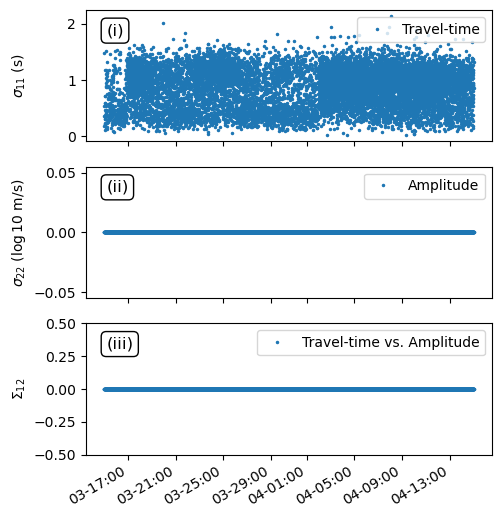

In [12]:
fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([0.8,1.1]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.90]
plt.subplot(311)
plt.plot(gamma_events["time"], gamma_events["sigma_time"], '.', markersize=3.0, label="Travel-time")
plt.ylabel(r"$\sigma_{11}$ (s)")
plt.legend(loc="upper right")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.subplot(312)
plt.plot(gamma_events["time"], gamma_events["sigma_amp"], '.', markersize=3.0, label="Amplitude")
plt.ylabel(r"$\sigma_{22}$ ($\log10$ m/s)")
plt.legend(loc="upper right")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.subplot(313)
plt.plot(gamma_events["time"], gamma_events["cov_time_amp"], '.', markersize=3.0, label="Travel-time vs. Amplitude")
plt.ylabel(r"$\Sigma_{12}$")
plt.ylim([-0.5, 0.5])
plt.legend(loc="upper right")
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.gcf().align_labels()
plt.savefig(figure_dir("covariance.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("covariance.pdf"), bbox_inches="tight")
plt.show();